<a href="https://colab.research.google.com/github/ruddysimon/ADS504-machine-learning-deep-learning/blob/ruddy-branch/Fake_news_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# import dependencies
import pandas as pd
import numpy as np
import csv

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data Understanding

In [8]:
fake_news_df = pd.read_csv("/content/drive/MyDrive/ADS504 - Machine Learning /resource/fake_news.csv")
display(fake_news_df)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [9]:
# check missing values in dataset
fake_news_df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

With 20,800 rows in your dataset, removing all rows with missing values would still leave a substantial amount of data. However, given that the "title" and "text" fields are likely very important for a fake news detection task, it may be better to avoid removing these rows if possible.

**Suggestion:**

For the "title" and "text" columns, replace missing values with a placeholder string such as "missing". This allows us to retain the rows while also acknowledging the absence of this important information.</br>
For the "author" column, replace missing values with another placeholder string like "unknown". The authorship may be less important in determining whether a news story is fake, so this approach allows us to keep the data without making potentially misleading assumptions.

In [10]:
# replace NaN values in 'title' and 'text' with 'missing'
fake_news_df['title'].fillna('missing', inplace=True)
fake_news_df['text'].fillna('missing', inplace=True)

# replace NaN values in 'author' with 'unknown'
fake_news_df['author'].fillna('unknown', inplace=True)

## Class Imbalance check

1    10413
0    10387
Name: label, dtype: int64


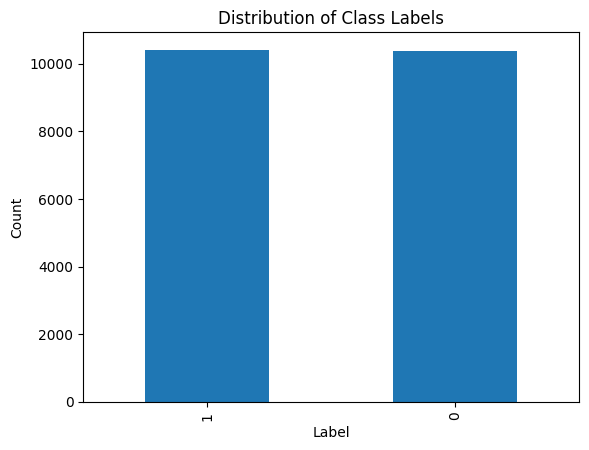

In [16]:
# check the distribution of the class labels
label_count = fake_news_df["label"].value_counts()
print(label_count)

label_count.plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

The